In [367]:
import pandas as pd
#from datasets.BrainAgeContinuous import BrainAgeContinuous
#from datasets.BrainAgeDataset import BrainAgeDataset
#from datasets.CatsinomDataset import CatsinomDataset
#from datasets.LIDCDataset import LIDCDataset
from models.unet3d import EncoderModelGenesis
import torchvision.models as tvmodels
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from statsmodels.distributions.empirical_distribution import ECDF
#import statsmodels.api as sm

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from scipy.stats import gaussian_kde, norm, multivariate_normal
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import torch.nn as nn

#from statsmodels.nonparametric.kernel_density import KDEMultivariate

from scipy.spatial.distance import seuclidean, euclidean, mahalanobis, pdist, squareform
from sklearn.random_projection import SparseRandomProjection
import active_dynamicmemory.utils as cutils
import pickle
from datasets.BatchDataset import CardiacBatch
from active_dynamicmemory.ActiveDynamicMemory import MemoryItem
from datasets.ContinuousDataset import CardiacContinuous
import seaborn as sns
import yaml
import active_dynamicmemory.runutils as rutils
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib

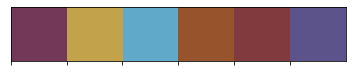

In [120]:
mapname = 'romaO'

cm_data = np.loadtxt(f"/home/mperkonigg/Documents/ScientificColourMaps6/{mapname}/{mapname}.txt")
colormap = LinearSegmentedColormap.from_list('scientific_cm', cm_data)
#x = np.linspace(0, 100, 25)[None, :]
#plt.imshow(x, aspect='auto',cmap=colormap)
#plt.axis('off')
#plt.show()
colormap = ListedColormap([cm_data[0], cm_data[85],cm_data[180], cm_data[45], cm_data[20], cm_data[227]], name='scientific_cm')
matplotlib.cm.register_cmap(cmap=colormap, name='scientific_cm')
sns.set_palette('scientific_cm')
sns.palplot(sns.color_palette())

In [2]:
def gram_matrix(input):
    # taken from: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    grams = []

    for i in range(a):
        features = input[i].view(b, c * d)  # resise F_XL into \hat F_XL
        G = torch.mm(features, features.t())  # compute the gram product
        grams.append(G.div(b * c * d))

    return grams
        
def gram_hook(m, input, output):
    grammatrices.append(gram_matrix(input[0]))

def register_hooks(layers):
    for layer in layers:
        layer.register_forward_hook(gram_hook)

In [3]:
device = torch.device('cuda')

stylemodel = tvmodels.resnet50(pretrained=True)
stylemodel.to(device)
stylemodel.eval()
gramlayers = [stylemodel.layer2[-1].conv1]
register_hooks(gramlayers)

In [6]:
grammatrices=[]
device = torch.device('cuda')
num_items = 128

ds_base = CardiacBatch('/project/catinous/cardiacslicessplitsingle.csv', split=['base'])
ds_train = CardiacBatch('/project/catinous/cardiacslicessplitsingle.csv', split=['train'])

init cardiac batch with datasetfile /project/catinous/cardiacslicessplitsingle.csv
init cardiac batch with datasetfile /project/catinous/cardiacslicessplitsingle.csv


In [12]:
for d in ds_base:
    print(d)
    break

(tensor([[[0.0237, 0.0209, 0.0091,  ..., 0.0164, 0.0182, 0.0282],
         [0.0109, 0.0109, 0.0200,  ..., 0.0182, 0.0118, 0.0227],
         [0.0346, 0.0218, 0.0155,  ..., 0.0109, 0.0164, 0.0209],
         ...,
         [0.0382, 0.0255, 0.0255,  ..., 0.1256, 0.1046, 0.0837],
         [0.0455, 0.0328, 0.0273,  ..., 0.1074, 0.0837, 0.0773],
         [0.0346, 0.0318, 0.0218,  ..., 0.1083, 0.0892, 0.0591]]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'Siemens', '/project/catinous/cardiac_data/singleSlices/D4M3Q2_sa/0_0.npy')


In [13]:
img = d[0]
img.shape

torch.Size([1, 240, 192])

In [9]:
df_base = ds_base.df

,scanner,filepath,t,slice,split,slicepath
0,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,0,base,/project/catinous/cardiac_data/singleSlices/D4...
1,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,1,base,/project/catinous/cardiac_data/singleSlices/D4...
2,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,2,base,/project/catinous/cardiac_data/singleSlices/D4...
3,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,3,base,/project/catinous/cardiac_data/singleSlices/D4...
4,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,4,base,/project/catinous/cardiac_data/singleSlices/D4...
...,...,...,...,...,...,...
1115,Siemens,/data/dataset/external/MandMs/nifti/J6K6P5/J6K...,9,8,base,/project/catinous/cardiac_data/singleSlices/J6...
1116,Siemens,/data/dataset/external/MandMs/nifti/J6K6P5/J6K...,9,9,base,/project/catinous/cardiac_data/singleSlices/J6...
1117,Siemens,/data/dataset/external/MandMs/nifti/J6K6P5/J6K...,9,10,base,/project/catinous/cardiac_data/singleSlices/J6...
1118,Siemens,/data/dataset/external/MandMs/nifti/J6K6P5/J6K...,9,11,base,/project/catinous/cardiac_data/singleSlices/J6...


In [31]:
matrices_for_embedding = []
base_matrices = []
grammatrices = []
scanners = []

for d in ds_base:
    img, targets, scanner, filepath = d
    
    x = torch.tensor(img[None, :, :, :]).to(device)
    x = torch.cat([x, x, x], dim=1)
    y_style = stylemodel(x.float())
    for gm in grammatrices[0]:
        base_matrices.append(gm.detach().cpu().numpy().flatten())
    grammatrices = []
    if scanner == 'Siemens':
        scanners.append(0)
    elif scanner == 'GE':
        scanners.append(1)
    elif scanner =='Philips':
        scanners.append(2)
    else:
        scanners.append(3)

matrices_for_embedding.extend(base_matrices)
            
for d in ds_train:
    img, targets, scanner, filepath = d
    
    x = torch.tensor(img[None, :,  :, :]).to(device)
    x = torch.cat([x, x, x], dim=1)
    y_style = stylemodel(x.float())
    for gm in grammatrices[0]:
        matrices_for_embedding.append(gm.detach().cpu().numpy().flatten())
    grammatrices = []
    if scanner == 'Siemens':
        scanners.append(0)
    elif scanner == 'GE':
        scanners.append(1)
    elif scanner =='Philips':
        scanners.append(2)
    else:
        scanners.append(3)

/home/mperkonigg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/mperkonigg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [32]:
transformer = PCA(random_state=1, n_components=30)
transformer.fit(base_matrices)

PCA(n_components=30, random_state=1)

In [33]:
trans_matrices = transformer.transform(matrices_for_embedding[:1000])
trans_matrices = np.concatenate([trans_matrices, transformer.transform(matrices_for_embedding[1000:2000])])
trans_matrices = np.concatenate([trans_matrices, transformer.transform(matrices_for_embedding[2000:3000])])
trans_matrices = np.concatenate([trans_matrices, transformer.transform(matrices_for_embedding[3000:])])

In [34]:
plt_df = pd.concat([ds_base.df, ds_train.df])

In [35]:
tsne = TSNE(n_components=2, perplexity=50)
elements_tsne = tsne.fit_transform(trans_matrices)
df_kde = pd.DataFrame({'x':elements_tsne[:, 0], 'y': elements_tsne[:, 1], 'scanner':scanners})

In [37]:
plt_df['emb_x'] = elements_tsne[:, 0]
plt_df['emb_y'] = elements_tsne[:, 1]
plt_df['scanner_cde'] = scanners

In [39]:
plt_df

,scanner,filepath,t,slice,split,slicepath,emb_x,emb_y,scanner_cde
0,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,0,base,/project/catinous/cardiac_data/singleSlices/D4...,-57.085796,7.983968,0
1,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,1,base,/project/catinous/cardiac_data/singleSlices/D4...,-57.344589,8.162851,0
2,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,2,base,/project/catinous/cardiac_data/singleSlices/D4...,-57.537830,28.735825,0
3,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,3,base,/project/catinous/cardiac_data/singleSlices/D4...,-57.342911,29.500608,0
4,Siemens,/data/dataset/external/MandMs/nifti/D4M3Q2/D4M...,0,4,base,/project/catinous/cardiac_data/singleSlices/D4...,-57.002247,29.448914,0
...,...,...,...,...,...,...,...,...,...
4293,Canon,/data/dataset/external/MandMs/nifti/K3P3Y6/K3P...,11,7,train,/project/catinous/cardiac_data/singleSlices/K3...,-11.249884,69.441284,3
4294,Canon,/data/dataset/external/MandMs/nifti/K3P3Y6/K3P...,11,8,train,/project/catinous/cardiac_data/singleSlices/K3...,-11.499054,70.256081,3
4295,Canon,/data/dataset/external/MandMs/nifti/K3P3Y6/K3P...,11,9,train,/project/catinous/cardiac_data/singleSlices/K3...,-11.490430,70.743881,3
4296,Canon,/data/dataset/external/MandMs/nifti/K3P3Y6/K3P...,11,10,train,/project/catinous/cardiac_data/singleSlices/K3...,-11.288959,71.411346,3


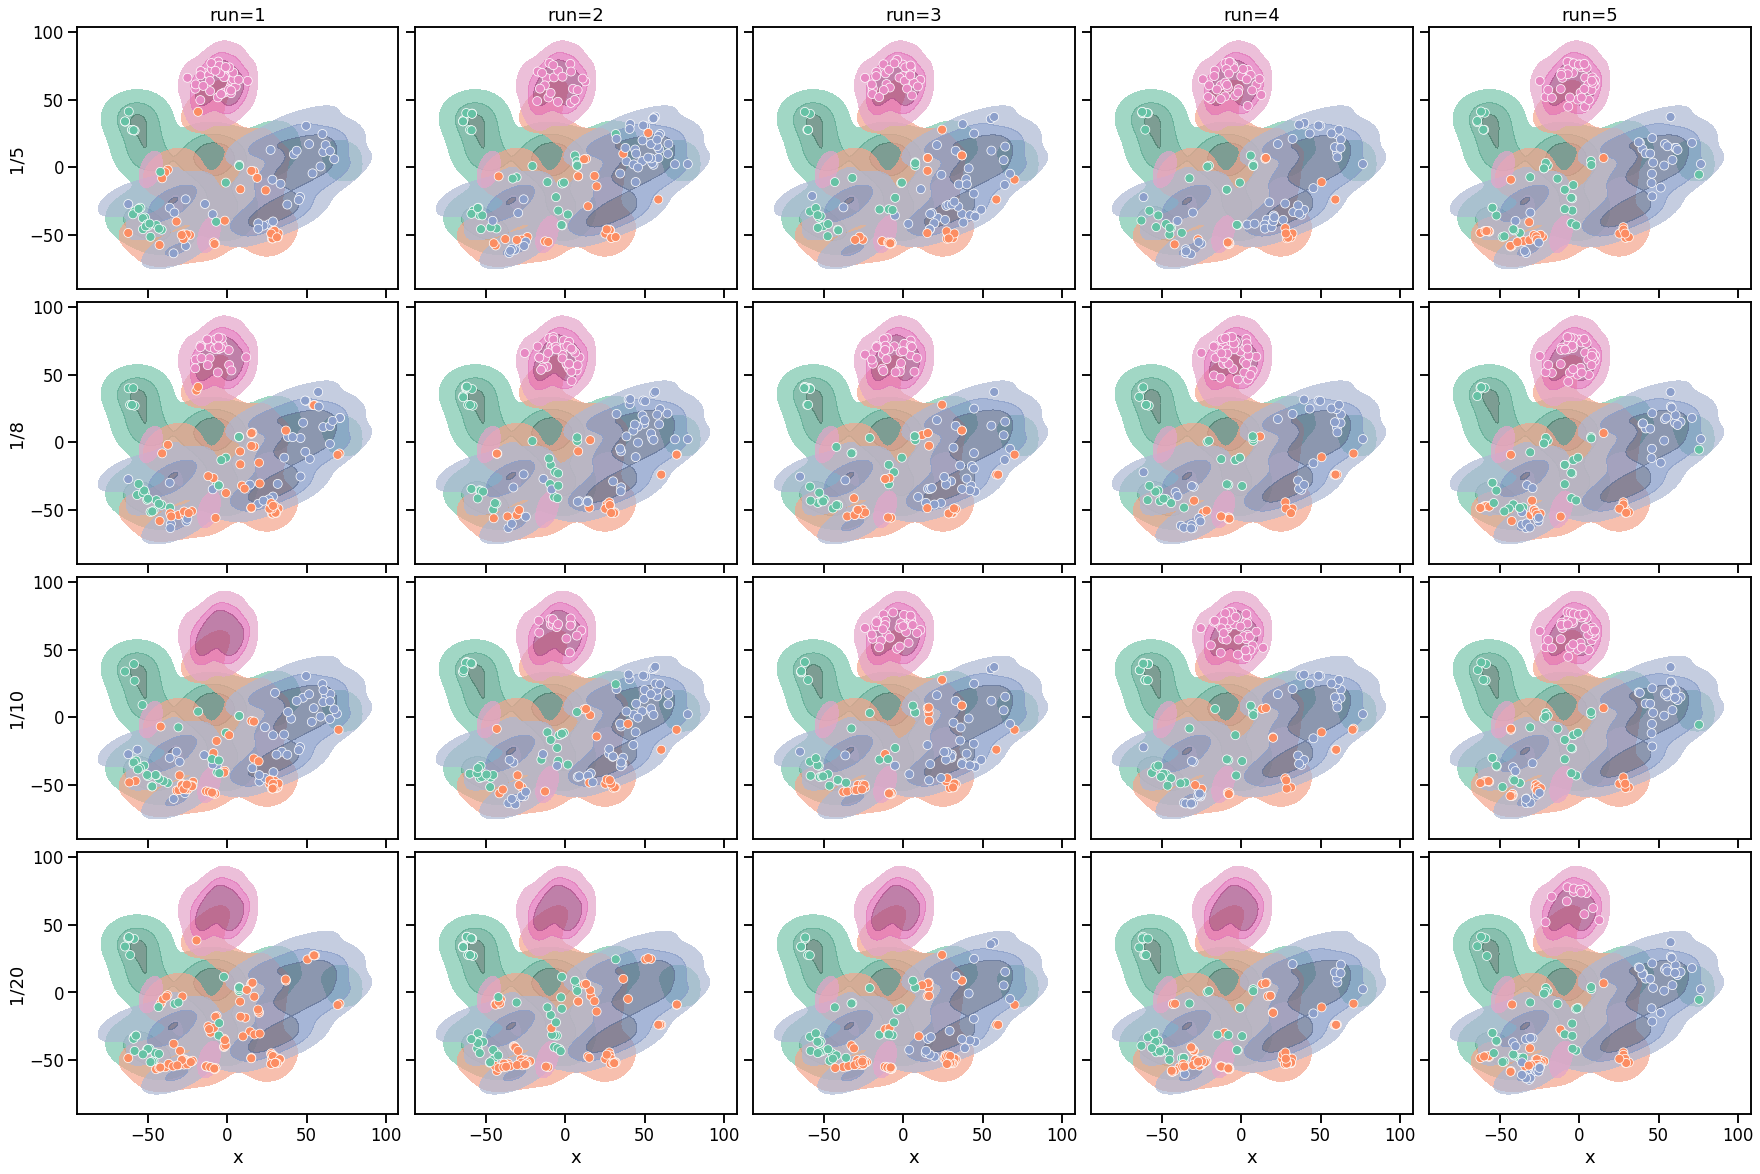

In [366]:
fig, ax = plt.subplots(4, 5, figsize=(30, 20), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)
sns.set_palette(palette=sns.color_palette('Set2'))

labels=['1/5', '1/8', '1/10', '1/20']

for k, train_file in enumerate(['cardiac_casa_5.yml', 'cardiac_casa_8.yml', 'cardiac_casa_10.yml', 'cardiac_casa_20.yml']):
    with open(f'./training_configs/{train_file}') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

        memdir = params['settings']['TRAINED_MEMORY_DIR']    

        for j, seed in enumerate([1, 2, 3, 4, 5]):

            params['trainparams']['seed'] = seed
            params['trainparams']['run_postfix'] = seed

            expname = rutils.get_expname(params['trainparams'])

            df = pd.read_csv(f'{memdir}/{expname}.csv')

            df_indices = [] 

            for i, row in df.iterrows():
                if row.filepath.endswith('.npy'):
                    df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
                else:
                    r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
                    df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

            sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=4), levels=4, alpha=0.7)
            n_c = len(plt_df.iloc[df_indices].scanner_cde.unique())
            sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=n_c),)
            ax[k][j].get_legend().remove()
            
        ax[k][0].set_ylabel(labels[k])
for i in range(5):
    ax[0][i].set_title(f'run={i+1}')
               

fig.savefig('/project/catinous/active_catinous/MELBA/output/results/ablation_memory_budget.pdf')

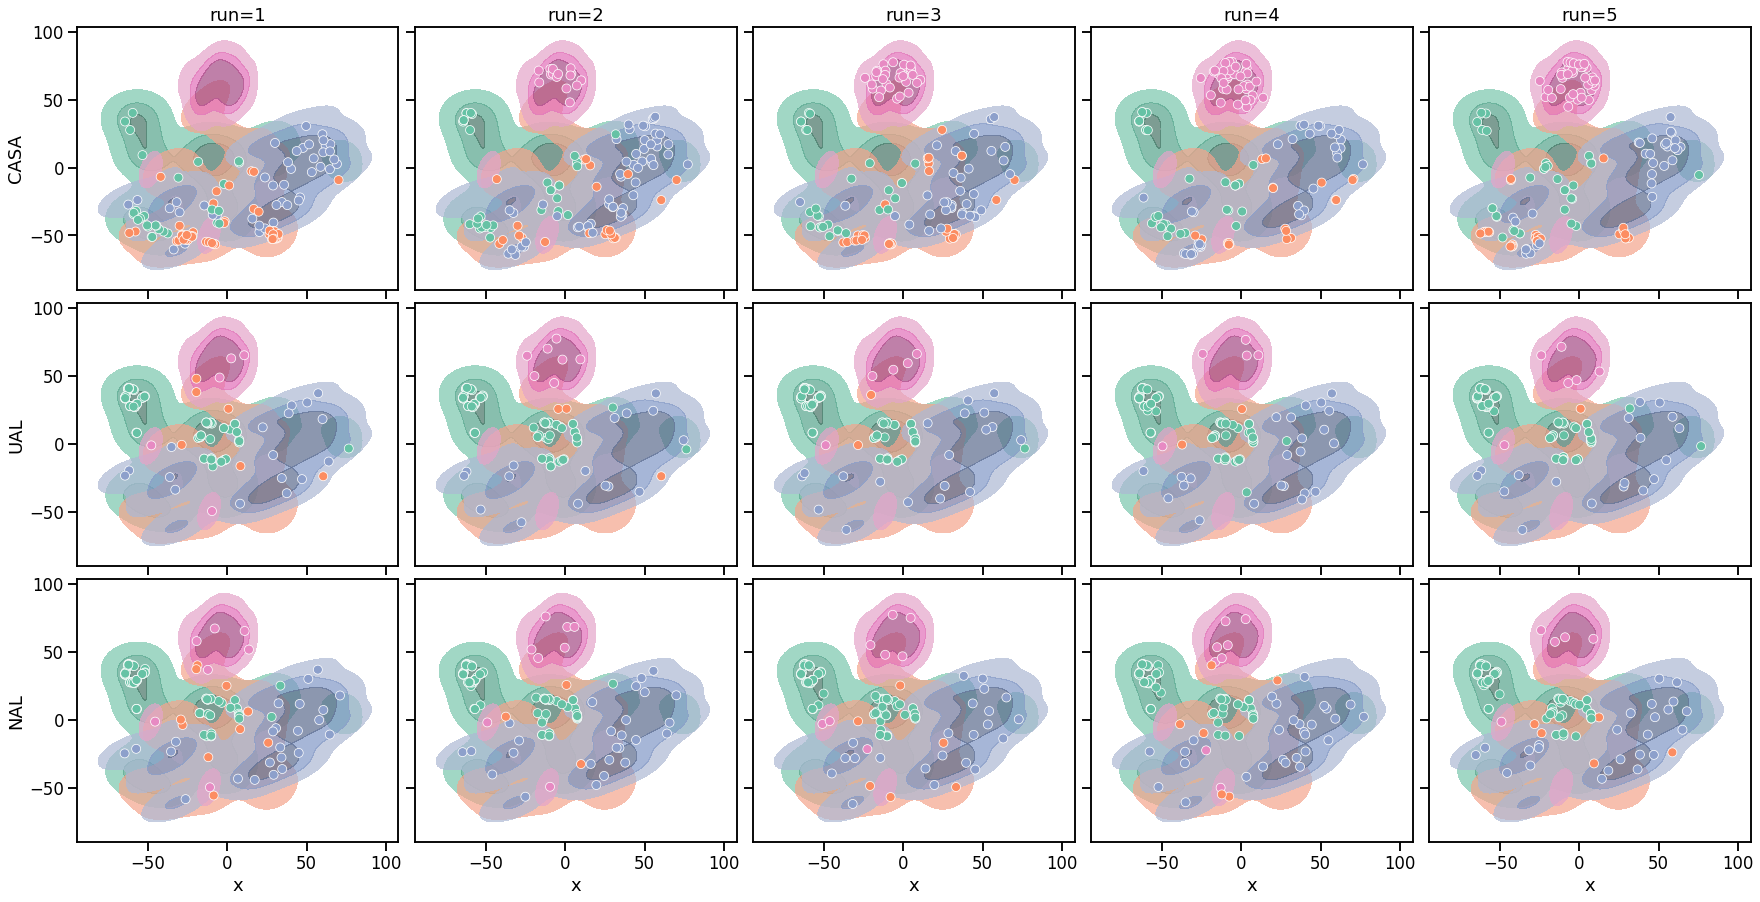

In [365]:
fig, ax = plt.subplots(3, 5, figsize=(30, 15), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.05, wspace=0.05)

sns.set_palette(palette=sns.color_palette('Set2'))

k=0
with open(f'./training_configs/cardiac_casa_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

    memdir = params['settings']['TRAINED_MEMORY_DIR']    

    for j, seed in enumerate([1, 2, 3, 4, 5]):

        params['trainparams']['seed'] = seed
        params['trainparams']['run_postfix'] = seed

        expname = rutils.get_expname(params['trainparams'])

        df = pd.read_csv(f'{memdir}/{expname}.csv')

        df_indices = [] 

        for i, row in df.iterrows():
            if row.filepath.endswith('.npy'):
                df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
            else:
                r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
                df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

        sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=4), levels=4, alpha=0.7)
        n_c = len(plt_df.iloc[df_indices].scanner_cde.unique())
        sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=n_c),)
        ax[k][j].get_legend().remove()
    ax[k][0].set_ylabel('CASA')

        
k=1
with open(f'./training_configs/cardiac_uncertainty_10.yml') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

        memdir = params['settings']['TRAINED_MEMORY_DIR']    

        for j, seed in enumerate([6, 7, 8, 9, 10]):

            params['trainparams']['seed'] = seed
            params['trainparams']['run_postfix'] = seed

            expname = rutils.get_expname(params['trainparams'])

            df = pd.read_csv(f'{memdir}/{expname}.csv')

            df_indices = [] 

            for i, row in df.iterrows():
                if row.filepath.endswith('.npy'):
                    df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
                else:
                    r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
                    df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

            sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=4), levels=4, alpha=0.7)
            n_c = len(plt_df.iloc[df_indices].scanner_cde.unique())
            sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=n_c),)
            ax[k][j].get_legend().remove()
        ax[k][0].set_ylabel('UAL')

        
k=2
with open(f'./training_configs/cardiac_naive_10.yml') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

        memdir = params['settings']['TRAINED_MEMORY_DIR']    

        for j, seed in enumerate([6, 7, 8, 9, 10]):

            params['trainparams']['seed'] = seed
            params['trainparams']['run_postfix'] = seed

            expname = rutils.get_expname(params['trainparams'])

            df = pd.read_csv(f'{memdir}/{expname}.csv')

            df_indices = [] 

            for i, row in df.iterrows():
                if row.filepath.endswith('.npy'):
                    df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
                else:
                    r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
                    df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

            sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=4), levels=4, alpha=0.7)
            n_c = len(plt_df.iloc[df_indices].scanner_cde.unique())
            sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[k][j], palette=sns.color_palette('Set2', n_colors=n_c),)
            ax[k][j].get_legend().remove()
        ax[k][0].set_ylabel('NAL')

for i in range(5):
    ax[0][i].set_title(f'run={i+1}')
               

fig.savefig('/project/catinous/active_catinous/MELBA/output/results/ablation_memory_methods.pdf')

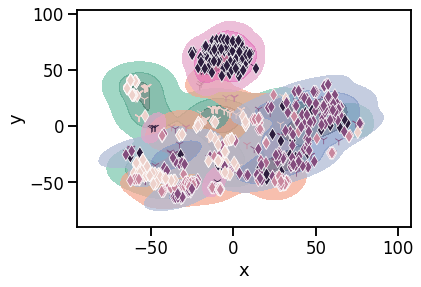

In [353]:
fig, ax = plt.subplots(1, 1)
sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, palette=sns.color_palette('Set2', n_colors=4), levels=4, alpha=0.7, ax=ax)
with open(f'./training_configs/cardiac_uncertainty_10.yml') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

memdir = params['settings']['TRAINED_MEMORY_DIR']    

for j, seed in enumerate([6, 7, 8, 9, 10]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')

    df_indices = [] 

    for i, row in df.iterrows():
        if row.filepath.endswith('.npy'):
            df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
        else:
            r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
            df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

    sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax, marker='1')
    
with open(f'./training_configs/cardiac_casa_10.yml') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

memdir = params['settings']['TRAINED_MEMORY_DIR']    

for j, seed in enumerate([1,2,3,4,5]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')

    df_indices = [] 

    for i, row in df.iterrows():
        if row.filepath.endswith('.npy'):
            df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
        else:
            r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
            df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

    sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax, marker='d')
ax.get_legend().remove()

/project/catinous/cardiac_data/singleSlices/W5Z4Z8_sa/11_9.npy
/project/catinous/cardiac_data/singleSlices/F1K2S9_sa/23_3.npy
/project/catinous/cardiac_data/singleSlices/H0K3Q4_sa/24_1.npy
/project/catinous/cardiac_data/singleSlices/Q4W5Z8_sa/10_4.npy
/project/catinous/cardiac_data/singleSlices/P3T5U1_sa/27_4.npy
/project/catinous/cardiac_data/singleSlices/N5S7Y1_sa/0_7.npy
/project/catinous/cardiac_data/singleSlices/E0J2Z9_sa/11_13.npy
/project/catinous/cardiac_data/singleSlices/H2M9S1_sa/23_9.npy
/project/catinous/cardiac_data/singleSlices/N5S7Y1_sa/0_5.npy
/project/catinous/cardiac_data/singleSlices/B5L5Y4_sa/24_6.npy
/project/catinous/cardiac_data/singleSlices/L1Q1Z5_sa/0_4.npy
/project/catinous/cardiac_data/singleSlices/C0N8P4_sa/24_8.npy
/project/catinous/cardiac_data/singleSlices/C5M4S2_sa/0_2.npy
/project/catinous/cardiac_data/singleSlices/D0H9I4_sa/10_0.npy
/project/catinous/cardiac_data/singleSlices/A8C9U8_sa/28_1.npy
/project/catinous/cardiac_data/singleSlices/D9F5P1_sa/0_4.

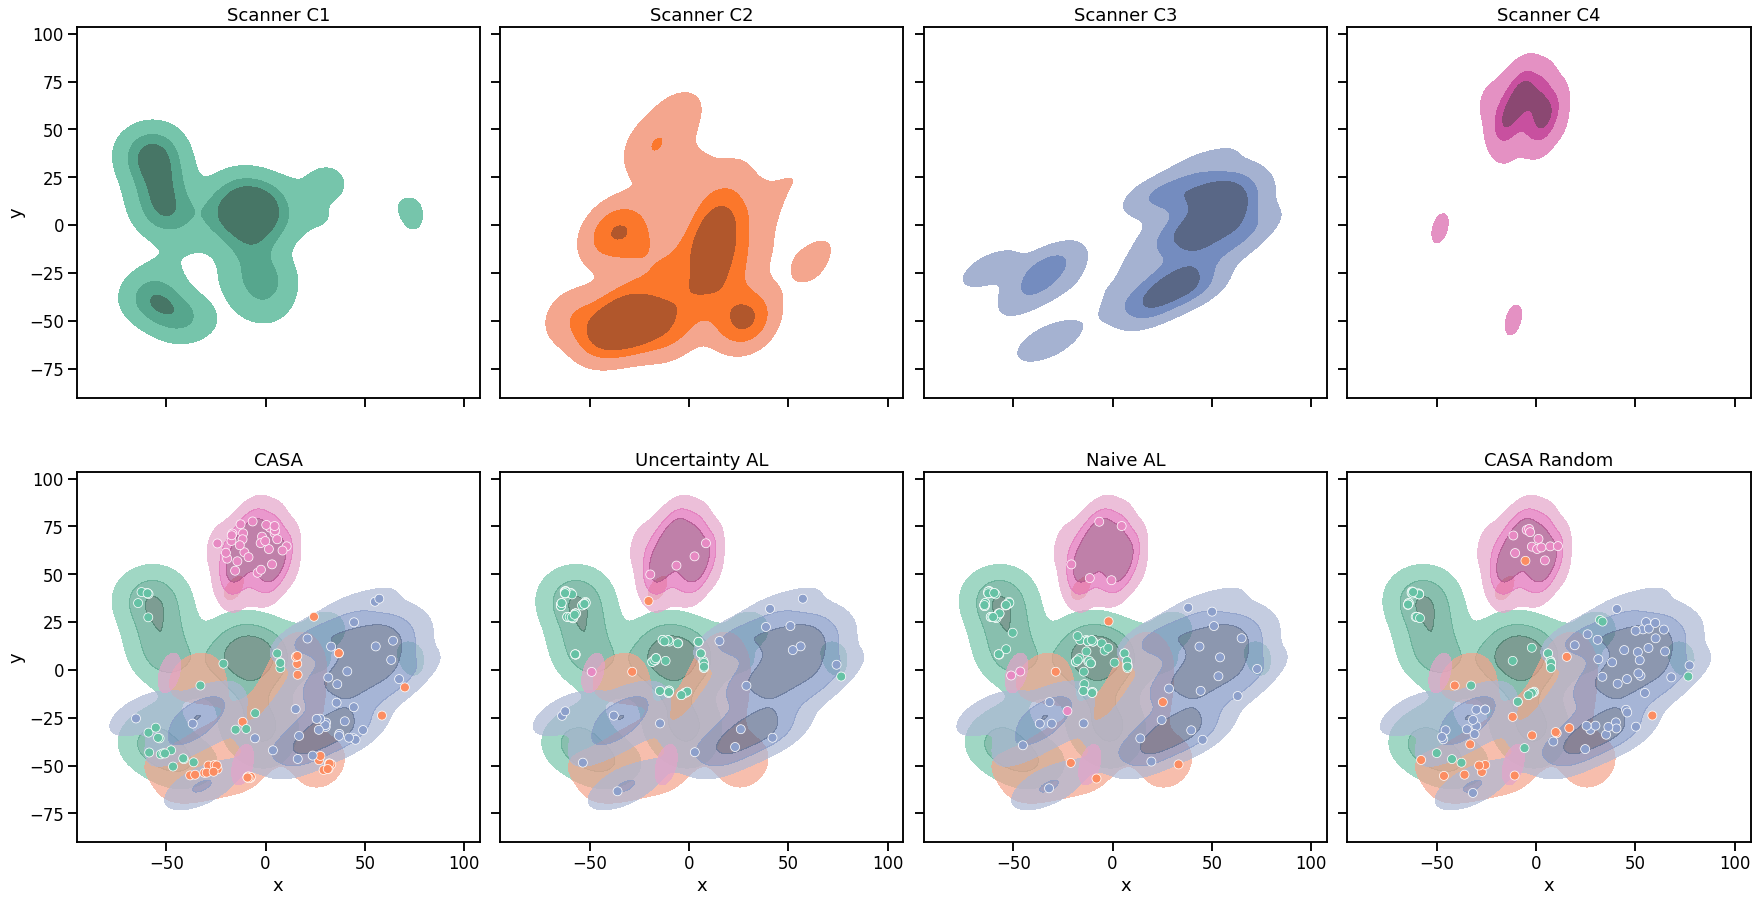

In [339]:
fig, ax = plt.subplots(2, 4, figsize=(30, 15), sharex=True, sharey=True)

plt.subplots_adjust(wspace=0.05)

#sns.set_palette(palette=sns.color_palette())
#sns.kdeplot(data=df_kde.iloc[:len(base_matrices)], x='x', y='y', shade=True, thres=0.1, ax=ax[0][0])

for j, s in enumerate([0, 1, 2, 3]):
    sns.kdeplot(data=df_kde.loc[df_kde.scanner==s], x='x', y='y', shade=True, ax=ax[0][j], color=sns.color_palette('Set2')[j], levels=4,thresh=0.1)

ax[0][0].set_title('Scanner C1')
ax[0][1].set_title('Scanner C2')
ax[0][2].set_title('Scanner C3')
ax[0][3].set_title('Scanner C4')

for k, train_file in enumerate(['cardiac_casa_10.yml']):
    with open(f'./training_configs/{train_file}') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

        memdir = params['settings']['TRAINED_MEMORY_DIR']    

        params['trainparams']['seed'] = 3
        params['trainparams']['run_postfix'] = 3

        expname = rutils.get_expname(params['trainparams'])

        df = pd.read_csv(f'{memdir}/{expname}.csv')

        df_indices = [] 

        for i, row in df.iterrows():
            if row.filepath.endswith('.npy'):
                df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
            else:
                r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
                df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

        sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[1][0], palette=sns.color_palette('Set2', n_colors=4),alpha=0.7, thresh=0.1, levels=4)
        sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[1][0], palette=sns.color_palette('Set2', n_colors=4))
        ax[1][0].set_title('CASA')
        ax[1][0].get_legend().remove()

with open(f'./training_configs/cardiac_uncertainty_10.yml') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

        memdir = params['settings']['TRAINED_MEMORY_DIR']    


        params['trainparams']['seed'] = 8
        params['trainparams']['run_postfix'] = 8

        expname = rutils.get_expname(params['trainparams'])

        df = pd.read_csv(f'{memdir}/{expname}.csv')

        df_indices = [] 

        for i, row in df.iterrows():
            if row.filepath.endswith('.npy'):
                df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
            else:
                r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
                df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

        sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[1][1], palette=sns.color_palette('Set2', n_colors=4), alpha=0.7, thresh=0.1, levels=4)
        sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[1][1], palette=sns.color_palette('Set2', n_colors=4))
        ax[1][1].set_title('Uncertainty AL')
        ax[1][1].get_legend().remove()

        
with open(f'./training_configs/cardiac_naive_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

    memdir = params['settings']['TRAINED_MEMORY_DIR']    


    params['trainparams']['seed'] = 8
    params['trainparams']['run_postfix'] = 8

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')

    df_indices = [] 

    for i, row in df.iterrows():
        if row.filepath.endswith('.npy'):
            df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
        else:
            r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
            df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

    sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[1][2], palette=sns.color_palette('Set2', n_colors=4), alpha=0.7,thresh=0.1, levels=4)
    sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[1][2], palette=sns.color_palette('Set2', n_colors=4))
    
    ax[1][2].set_title('Naive AL')
    ax[1][2].get_legend().remove()
    
    
with open(f'./training_configs/ablation_cardiac/cardiac_casa_10_random.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

    memdir = params['settings']['TRAINED_MEMORY_DIR']    


    params['trainparams']['seed'] = 3
    params['trainparams']['run_postfix'] = 3

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')

    df_indices = [] 

    for i, row in df.iterrows():
        if row.filepath.endswith('.npy'):
            print(row.filepath)
            df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
        else:
            r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
            df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

    sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[1][3], palette=sns.color_palette('Set2', n_colors=4), alpha=0.7,thresh=0.1, levels=4)
    sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[1][3], palette=sns.color_palette('Set2', n_colors=4))
    
    ax[1][3].set_title('CASA Random')
    ax[1][3].get_legend().remove()
    
#fig.tight_layout()
#fig.savefig('/project/catinous/active_catinous/MELBA/output/results/memory_embeddings.pdf')

In [ ]:
with open(f'./training_configs/ca.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

    memdir = params['settings']['TRAINED_MEMORY_DIR']    


    params['trainparams']['seed'] = 8
    params['trainparams']['run_postfix'] = 8

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')

    df_indices = [] 

    for i, row in df.iterrows():
        if row.filepath.endswith('.npy'):
            df_indices.append(plt_df.loc[plt_df.slicepath==row.filepath].index[0])
        else:
            r_filepath = plt_df.loc[plt_df.filepath==row.filepath].sample().slicepath.values[0] #this is a little hack due to a small bug in dataset def.
            df_indices.append(plt_df.loc[plt_df.slicepath==r_filepath].index[0])        

    sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, ax=ax[1][2], palette=sns.color_palette('Set2', n_colors=4), alpha=0.7,thresh=0.1, levels=4)
    sns.scatterplot(data=plt_df.iloc[df_indices], x='emb_x', y='emb_y', hue='scanner_cde', ax=ax[1][2], palette=sns.color_palette('Set2', n_colors=4))

In [288]:
sns.__version__

'0.11.0'

<AxesSubplot:xlabel='x', ylabel='y'>

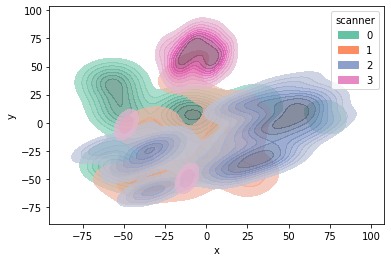

In [284]:
sns.kdeplot(data=df_kde, x='x', y='y', hue='scanner', shade=True, palette=sns.color_palette('alpha_cm', n_colors=4), alpha=0.7)

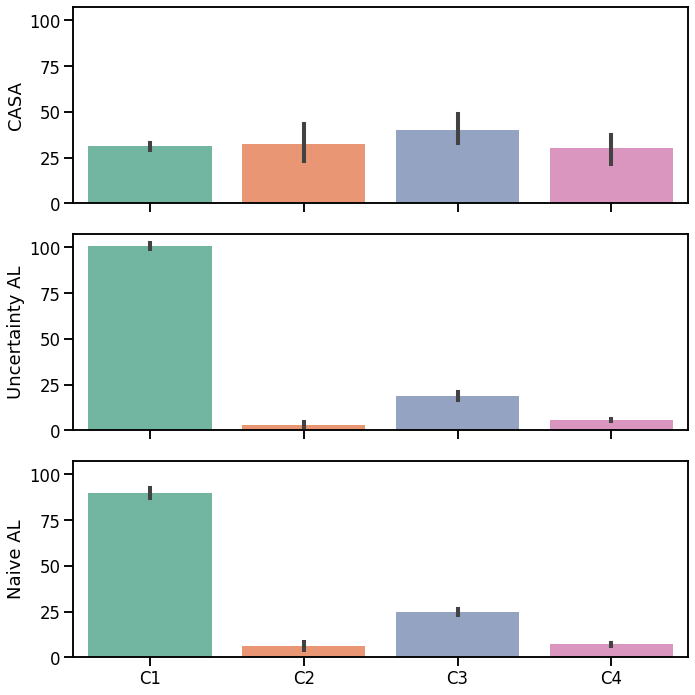

In [333]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 10))
plt.subplots_adjust(hspace=0.05)

sns.set_context('talk')

with open('./training_configs/cardiac_casa_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']
sns.set_palette(sns.color_palette('Set2'))
df_mems = pd.DataFrame()

for j, seed in enumerate([1, 2, 3, 4, 5]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=['Siemens', 'GE', 'Philips', 'Canon'], ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('CASA')

with open('./training_configs/cardiac_uncertainty_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([6, 7, 8, 9, 10]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=['Siemens', 'GE', 'Philips', 'Canon'], ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('Uncertainty AL')

with open('./training_configs/cardiac_naive_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([6, 7, 8, 9, 10]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=['Siemens', 'GE', 'Philips', 'Canon'], ax=ax[2])
ax[2].set_xlabel('')
ax[2].set_xticklabels(['C1', 'C2', 'C3', 'C4'])
ax[2].set_ylabel('Naive AL')

fig.tight_layout()
fig.savefig('/project/catinous/active_catinous/MELBA/output/results/memory_counts.pdf')

<AxesSubplot:xlabel='scanner', ylabel='filepath'>

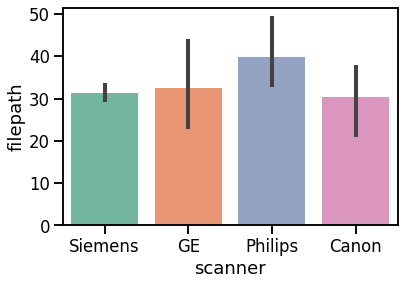

In [422]:
with open('./training_configs/ablation_cardiac/cardiac_casa_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([1, 2, 3, 4, 5]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=['Siemens', 'GE', 'Philips', 'Canon'])

In [423]:
df_mems.groupby(['scanner', 'seed']).count().reset_index().groupby('scanner').mean()

,seed,filepath,pseudodomain,target
scanner,,,,
Canon,3.5,30.25,30.25,30.25
GE,3.0,32.60,32.60,32.60
Philips,3.0,39.80,39.80,39.80
Siemens,3.0,31.40,31.40,31.40


<AxesSubplot:xlabel='scanner', ylabel='filepath'>

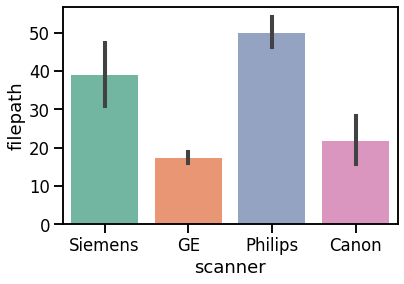

In [418]:
with open('./training_configs/ablation_cardiac/cardiac_casa_10_random.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([1, 2, 3, 4, 5]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=['Siemens', 'GE', 'Philips', 'Canon'])

<AxesSubplot:xlabel='scanner', ylabel='filepath'>

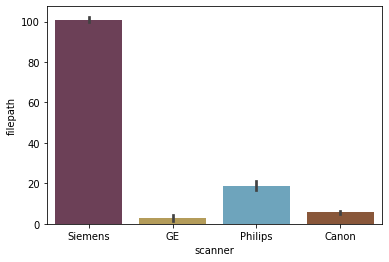

In [303]:
with open('./training_configs/cardiac_uncertainty_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([6, 7, 8, 9, 10]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=['Siemens', 'GE', 'Philips', 'Canon'])

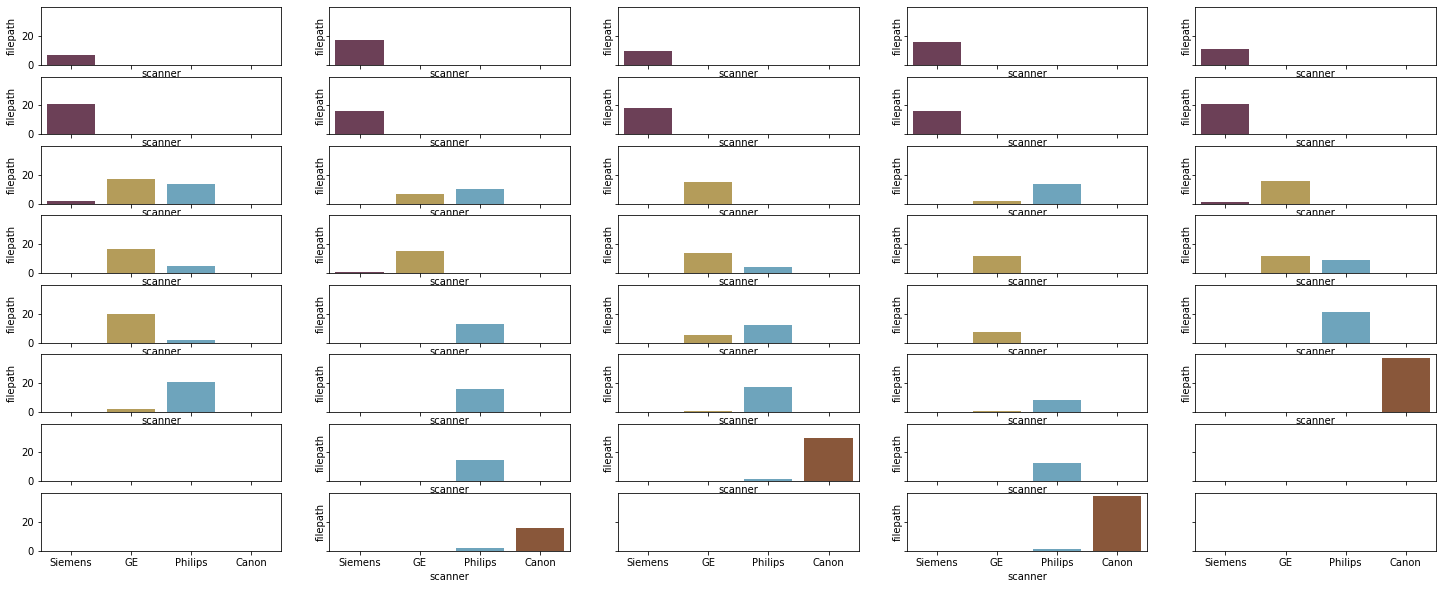

In [173]:
fig, ax = plt.subplots(len(df_mems.pseudodomain.unique()), 5, sharex=True, sharey=True, figsize=(25, 10))

for j in [1, 2, 3, 4, 5]:

    df_temp = df_mems.loc[df_mems.seed==j].groupby(['pseudodomain', 'scanner']).count().reset_index()
    for i in df_temp.pseudodomain.unique():
        df_pd = df_temp.loc[df_temp.pseudodomain==i]
        for s in ['Siemens', 'GE', 'Philips', 'Canon']:
            if len(df_pd.loc[df_pd.scanner==s])==0:
                df_temp = df_temp.append({'pseudodomain':i, 'scanner':s, 'filepath':0, 'target':0, 'seed':0}, ignore_index=True)


    for i in df_temp.pseudodomain.unique():
        sns.barplot(data=df_temp.loc[df_temp.pseudodomain==i], x='scanner', y='filepath', ax=ax[i][j-1], order=['Siemens', 'GE', 'Philips', 'Canon'])

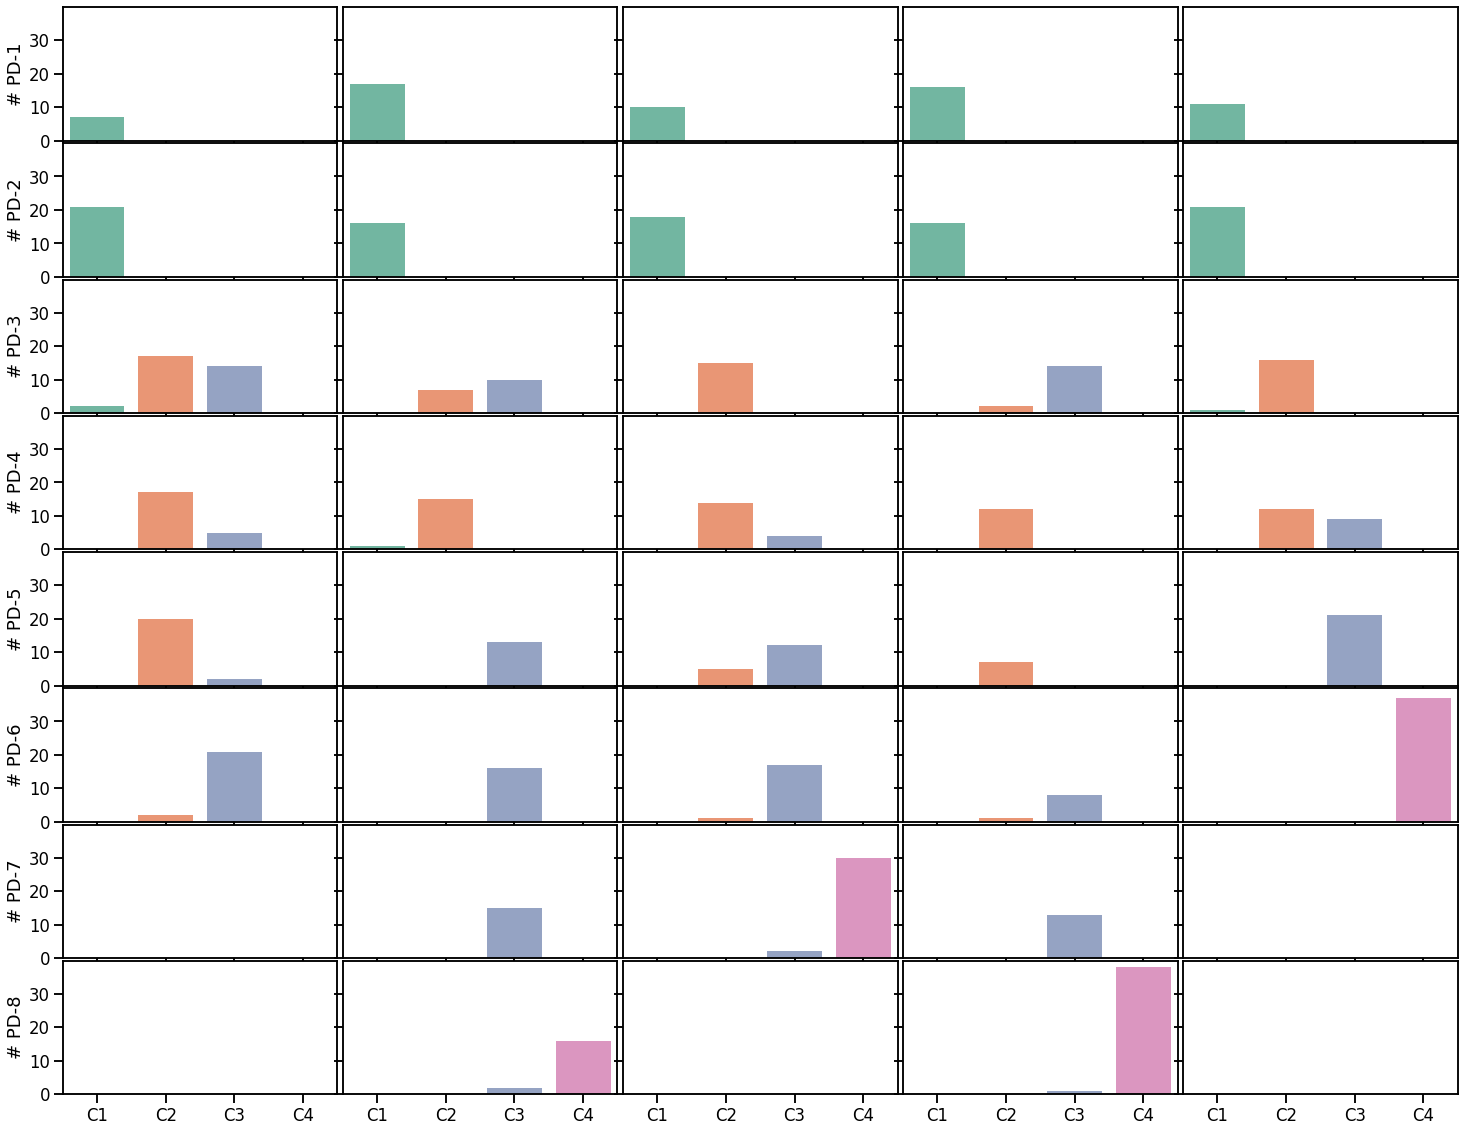

In [417]:
fig, ax = plt.subplots(len(df_mems.pseudodomain.unique()), 5, sharex=True, sharey=True, figsize=(25, 20))
plt.subplots_adjust(wspace=0.02, hspace=0.02)

for j in [1, 2, 3, 4, 5]:

    df_temp = df_mems.loc[df_mems.seed==j].groupby(['pseudodomain', 'scanner']).count().reset_index()
    for i in df_temp.pseudodomain.unique():
        df_pd = df_temp.loc[df_temp.pseudodomain==i]
        for s in ['Siemens', 'GE', 'Philips', 'Canon']:
            if len(df_pd.loc[df_pd.scanner==s])==0:
                df_temp = df_temp.append({'pseudodomain':i, 'scanner':s, 'filepath':0, 'target':0, 'seed':0}, ignore_index=True)


    for i in df_temp.pseudodomain.unique():
        sns.barplot(data=df_temp.loc[df_temp.pseudodomain==i], x='scanner', y='filepath', ax=ax[i][j-1], order=['Siemens', 'GE', 'Philips', 'Canon'])
        ax[i][j-1].set_ylabel('')
        ax[i][j-1].set_xlabel('')
        
    if j==1:
        for i in range(8):
            ax[i][j-1].set_ylabel(f'# PD-{i+1}')
    
    ax[7][j-1].set_xticklabels(['C1', 'C2', 'C3', 'C4'])
fig.savefig('/project/catinous/active_catinous/MELBA/output/results/mem_pd_allruns.pdf')

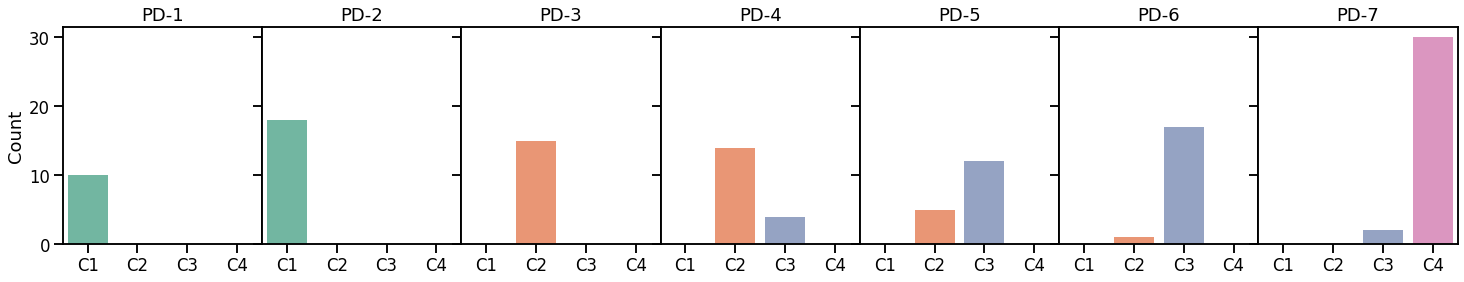

In [407]:
fig, ax = plt.subplots(1, 7, sharex=True, sharey=True, figsize=(25, 4))
plt.subplots_adjust(wspace=0.00, hspace=0.00)

j=3

df_temp = df_mems.loc[df_mems.seed==j].groupby(['pseudodomain', 'scanner']).count().reset_index()
for i in df_temp.pseudodomain.unique():
    df_pd = df_temp.loc[df_temp.pseudodomain==i]
    for s in ['Siemens', 'GE', 'Philips', 'Canon']:
        if len(df_pd.loc[df_pd.scanner==s])==0:
            df_temp = df_temp.append({'pseudodomain':i, 'scanner':s, 'filepath':0, 'target':0, 'seed':0}, ignore_index=True)


for i in df_temp.pseudodomain.unique():
    sns.barplot(data=df_temp.loc[df_temp.pseudodomain==i], x='scanner', y='filepath', ax=ax[i], order=['Siemens', 'GE', 'Philips', 'Canon'])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title(f'PD-{i+1}')
    ax[i].set_xticklabels(['C1', 'C2', 'C3', 'C4'])
ax[0].set_ylabel('Count')
fig.savefig('/project/catinous/active_catinous/MELBA/output/results/mem_pd_distribution.pdf')

In [379]:
#for k, train_file in enumerate(['cardiac_casa_5.yml', 'cardiac_casa_8.yml', 'cardiac_casa_10.yml', 'cardiac_casa_20.yml']):
with open(f'./training_configs/cardiac_casa_8.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

    memdir = params['settings']['TRAINED_MEMORY_DIR']    

    for j, seed in enumerate([1, 2, 3, 4, 5]):

        params['trainparams']['seed'] = seed
        params['trainparams']['run_postfix'] = seed

        expname = rutils.get_expname(params['trainparams'])
        
        with open(f'{memdir}/{expname}.txt') as f:
            print(f.readlines()[1])

label counter: 537
label counter: 505
label counter: 396
label counter: 471
label counter: 261


In [387]:
with open(f'./training_configs/brainage_uncertainty_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

    memdir = params['settings']['TRAINED_MEMORY_DIR']    

    for j, seed in enumerate([1, 2, 3, 4, 5]):

        params['trainparams']['seed'] = seed
        params['trainparams']['run_postfix'] = seed

        expname = rutils.get_expname(params['trainparams'])
        
        with open(f'{memdir}/{expname}.txt') as f:
            print(f.readlines()[1])

label counter: 189
label counter: 189
label counter: 189
label counter: 189
label counter: 189


In [378]:
with open(f'./training_configs/cardiac_naive_8.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

    memdir = params['settings']['TRAINED_MEMORY_DIR']    

    for j, seed in enumerate([1, 2, 3, 4, 5]):

        params['trainparams']['seed'] = seed
        params['trainparams']['run_postfix'] = seed

        expname = rutils.get_expname(params['trainparams'])
        
        with open(f'{memdir}/{expname}.txt') as f:
            print(f.readlines()[1])

label counter: 537
label counter: 537
label counter: 537
label counter: 537
label counter: 537


<AxesSubplot:xlabel='scanner', ylabel='filepath'>

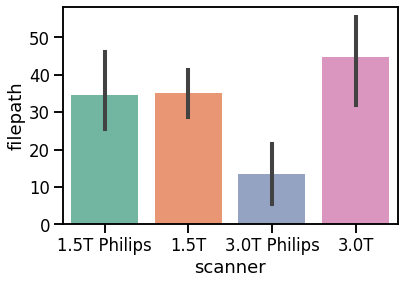

In [384]:
with open('./training_configs/brainage_casa_10.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([1, 2, 3, 4, 5]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=params['trainparams']['order'])

<AxesSubplot:xlabel='scanner', ylabel='filepath'>

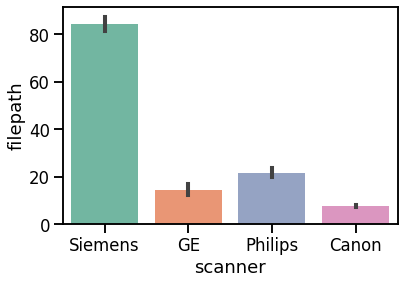

In [389]:
with open('./training_configs/ablation_cardiac/cardiac_naive_10_random.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([1, 2, 3, 4, 5]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=params['trainparams']['order'])

<AxesSubplot:xlabel='scanner', ylabel='filepath'>

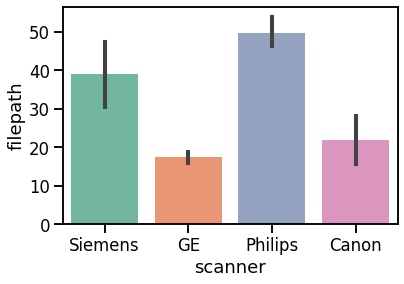

In [388]:
with open('./training_configs/ablation_cardiac/cardiac_casa_10_random.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
    
memdir = params['settings']['TRAINED_MEMORY_DIR']

df_mems = pd.DataFrame()

for j, seed in enumerate([1, 2, 3, 4, 5]):

    params['trainparams']['seed'] = seed
    params['trainparams']['run_postfix'] = seed

    expname = rutils.get_expname(params['trainparams'])

    df = pd.read_csv(f'{memdir}/{expname}.csv')
    df['seed'] = seed
    df_mems = df_mems.append(df)
sns.barplot(data=df_mems.groupby(['scanner', 'seed']).count().reset_index(), x='scanner', y='filepath', orient='v', order=params['trainparams']['order'])

In [383]:
params['trainparams']['order']

['1.5T Philips', '1.5T', '3.0T Philips', '3.0T']